# Random Forest Model

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Uncomment this to use sklearn's RandomForestClassifier:
# from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from collections import Counter

In [2]:

# Load the data
df = pd.read_csv('swell-data/Blacks_Beach_North_San_Diego_County_swell_data - Blacks_Beach_North_San_Diego_County_swell_data.csv.csv')
print("Data loaded")

# Preprocess the data
# Convert 'Date' to datetime and extract relevant features
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month

# Select relevant features
features = ['Time', 'Wave Height (ft)', 'Primary Swell (ft)', 'Primary Swell (seconds)', 
            'Wind (kts)', 'Wave Energy', 'Consistency', 'DayOfWeek', 'Month']
X = df[features]
y = df['w/nw']
print("Features selected")

Data loaded
Features selected


In [3]:
# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Custom RandomForestClassifier class

Same functionality as importing RandomForestClassifier from sklearn.ensemble. If sklearn's is preferred, uncomment in imports and not run the following code cell.

In [4]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def _gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        return 1 - np.sum((counts / len(y)) ** 2)

    def _split(self, X, y, feature, threshold):
        left_mask = X[:, feature] <= threshold
        return (X[left_mask], y[left_mask], X[~left_mask], y[~left_mask])

    def _best_split(self, X, y):
        best_gini = float('inf')
        best_feature, best_threshold = None, None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                _, y_left, _, y_right = self._split(X, y, feature, threshold)
                gini = (len(y_left) * self._gini(y_left) + len(y_right) * self._gini(y_right)) / len(y)
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _build_tree(self, X, y, depth=0):
        if len(np.unique(y)) == 1 or (self.max_depth and depth == self.max_depth):
            return Counter(y).most_common(1)[0][0]

        feature, threshold = self._best_split(X, y)
        if feature is None:
            return Counter(y).most_common(1)[0][0]

        X_left, y_left, X_right, y_right = self._split(X, y, feature, threshold)
        
        return {
            'feature': feature,
            'threshold': threshold,
            'left': self._build_tree(X_left, y_left, depth + 1),
            'right': self._build_tree(X_right, y_right, depth + 1)
        }

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _predict_single(self, x, tree):
        if not isinstance(tree, dict):
            return tree
        if x[tree['feature']] <= tree['threshold']:
            return self._predict_single(x, tree['left'])
        return self._predict_single(x, tree['right'])

    def predict(self, X):
        return np.array([self._predict_single(x, self.tree) for x in X])

class RandomForestClassifier:
    def __init__(self, n_estimators=100, max_depth=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []
        self.feature_importances_ = None

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[idxs], y[idxs]

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        
        np.random.seed(self.random_state)
        self.trees = []
        for _ in range(self.n_estimators):
            tree = DecisionTree(max_depth=self.max_depth)
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
        
        self.feature_importances_ = np.zeros(X.shape[1])
        for tree in self.trees:
            self._update_feature_importances(tree.tree, 1.0)
        self.feature_importances_ /= self.n_estimators

    def _update_feature_importances(self, node, weight):
        if isinstance(node, dict):
            self.feature_importances_[node['feature']] += weight
            left_size = self._get_node_size(node['left'])
            right_size = self._get_node_size(node['right'])
            total_size = left_size + right_size
            if total_size > 0:
                left_weight = weight * left_size / total_size
                right_weight = weight * right_size / total_size
                self._update_feature_importances(node['left'], left_weight)
                self._update_feature_importances(node['right'], right_weight)

    def _get_node_size(self, node):
        if isinstance(node, dict):
            return self._get_node_size(node['left']) + self._get_node_size(node['right'])
        else:
            return 1

    def predict(self, X):
        X = np.array(X)
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return np.array([Counter(pred).most_common(1)[0][0] for pred in tree_preds.T])

    def predict_proba(self, X):
        X = np.array(X)
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        probas = []
        for pred in tree_preds.T:
            count = Counter(pred)
            total = sum(count.values())
            # Ensure we always have probabilities for both classes (0 and 1)
            proba = [count.get(0, 0) / total, count.get(1, 0) / total]
            probas.append(proba)
        return np.array(probas)

### Training

In [5]:
# Create and train the Random Forest model
print("creating random forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
print("model created")

creating random forest model...
model created


In [6]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)
print("Made predictions")

Made predictions


In [7]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Worth Surfing', 'Worth Surfing']))


Model Accuracy: 0.92

Classification Report:
                   precision    recall  f1-score   support

Not Worth Surfing       0.87      1.00      0.93        13
    Worth Surfing       1.00      0.85      0.92        13

         accuracy                           0.92        26
        macro avg       0.93      0.92      0.92        26
     weighted avg       0.93      0.92      0.92        26



In [8]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                   feature  importance
4               Wind (kts)    1.309593
0                     Time    0.593201
6              Consistency    0.444231
5              Wave Energy    0.423554
3  Primary Swell (seconds)    0.219800
2       Primary Swell (ft)    0.197641
1         Wave Height (ft)    0.149578
8                    Month    0.082755
7                DayOfWeek    0.076714



Feature importance plot saved as 'feature_importance_blacks_beach.png'


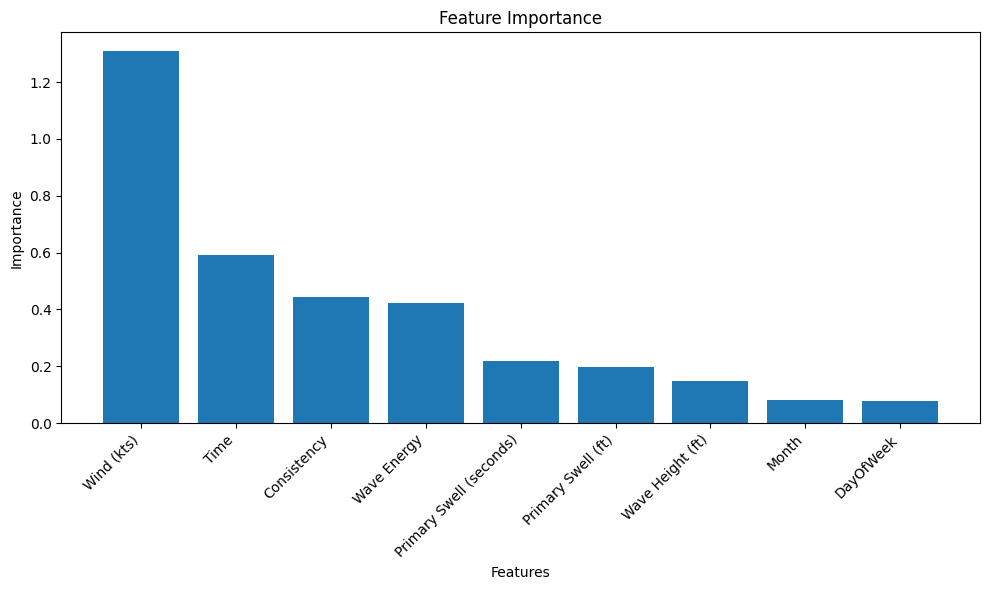

In [9]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('results/random-forest/feature_importance_blacks_beach.png')
print("\nFeature importance plot saved as 'feature_importance_blacks_beach.png'")

In [10]:
# Example prediction
example = X_test.iloc[0].values.reshape(1, -1)
prediction = rf_model.predict(example)
probability = rf_model.predict_proba(example)

print("\nExample Prediction:\n")
print(f"Features: {X_test.iloc[0].to_dict()}")
print(f"Prediction: {'Worth surfing' if prediction[0] == 1 else 'Not worth surfing'}")
print(f"Probability of being worth surfing: {probability[0][1]:.2f}")


Example Prediction:

Features: {'Time': 21.0, 'Wave Height (ft)': 6.0, 'Primary Swell (ft)': 7.3, 'Primary Swell (seconds)': 8.0, 'Wind (kts)': 17.0, 'Wave Energy': 439.0, 'Consistency': 78.0, 'DayOfWeek': 5.0, 'Month': 4.0}
Prediction: Worth surfing
Probability of being worth surfing: 1.00


In [11]:
# Save the model
import joblib
joblib.dump(rf_model, 'results/random-forest/surf_prediction_model_blacks_beach.joblib')
print("\nModel saved as 'surf_prediction_model_blacks_beach.joblib'")


Model saved as 'surf_prediction_model_blacks_beach.joblib'
